In [2]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

ModuleNotFoundError: No module named 'autogluon'

In [25]:
# 读取数据
data = pd.read_csv(r'D:\ArcgisData\pred_organic_p_n\feature_table\feature_table_result\all_result.csv')
print(len(data))
# 删除有缺失值的行
data.dropna(inplace=True)
len(data),data.columns

6808


(6806,
 Index(['Unnamed: 0', 'GDPOINTNPSOM', 'Ph', 'N', 'P', 'SOM', 'TWI5', 'TPI201',
        'TPI101', 'TPI11', 'TPI3', 'TMP', 'SOILQS', 'SLOP', 'PRE', 'NIGTH',
        'NDVI', 'DEM', 'CUR', 'ASP', 'PLCUR', 'POCUR', 'OSJL', 'LAT', 'LON',
        'DZ', 'DL'],
       dtype='object'))

In [26]:
data.drop(['Unnamed: 0','GDPOINTNPSOM',"N","P","SOM","SOILQS"], axis=1, inplace=True)
data.columns

Index(['Ph', 'TWI5', 'TPI201', 'TPI101', 'TPI11', 'TPI3', 'TMP', 'SLOP', 'PRE',
       'NIGTH', 'NDVI', 'DEM', 'CUR', 'ASP', 'PLCUR', 'POCUR', 'OSJL', 'LAT',
       'LON', 'DZ', 'DL'],
      dtype='object')

In [27]:
data = data[['Ph', 'TWI5', 'TPI201', 'TMP',
       'SLOP', 'PRE', 'NIGTH', 'NDVI', 'DZ','DL','LON','LAT']]
data.columns

Index(['Ph', 'TWI5', 'TPI201', 'TMP', 'SLOP', 'PRE', 'NIGTH', 'NDVI', 'DZ',
       'DL', 'LON', 'LAT'],
      dtype='object')

In [28]:
data['DL'] = data['DL'].astype(str)
data['DZ'] = data['DZ'].astype(str)
data.dtypes

Ph        float64
TWI5      float64
TPI201    float64
TMP       float64
SLOP      float64
PRE       float64
NIGTH     float64
NDVI      float64
DZ         object
DL         object
LON       float64
LAT       float64
dtype: object

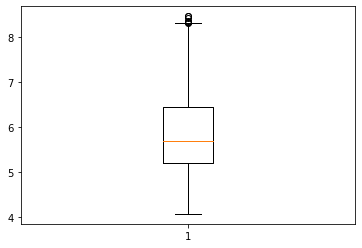

(6806, 12)


In [29]:
# 剔除离群值（Z-score）
z_scores = (data["Ph"]-data["Ph"].mean())/data["Ph"].std()
z_scores.describe()
# 设置阈值
z_score_filter= 2.8
z_filter_data = data[z_scores<z_score_filter]
z_filter_data
plt.boxplot(z_filter_data["Ph"])
plt.show()
print(z_filter_data.shape)

In [30]:
# 划分测试数据
train_data = data.sample(frac=0.8,random_state=0)   # 80%的数据用于训练
test_data = data.drop(train_data.index)                 # 20%的数据用于测试
train_data.sample()

,Ph,TWI5,TPI201,TMP,SLOP,PRE,NIGTH,NDVI,DZ,DL,LON,LAT
3496,6.21,6.951325,-73.20972,145.75,2.86258,845.0,0.26,3219.0,1,7,577570.0,2990830.0


In [31]:
label = 'Ph'
train_data[label].describe()

count    5445.000000
mean        5.904966
std         0.941038
min         4.070000
25%         5.190000
50%         5.690000
75%         6.440000
max         8.460000
Name: Ph, dtype: float64

In [18]:
# TabularPredictor.load("AutogluonModels\ag-20230802_083815\")  全要素
# TabularPredictor.load("AutogluonModels\ag-20230803_041226\")  全要素  presets="best_quality"

# predictor = TabularPredictor(label=label).fit(train_data,time_limit=6000,presets="best_quality")
# predictor = TabularPredictor.load(r"AutogluonModels\ag-20230803_041226")

# 模型存放位置
model_path = r'D:\ArcgisData\pred_ph\ph_pred_moudle\normal3'
# model_path = r'D:\ArcgisData\pred_organic\organic_pred_moudle\对数化'
predictor = TabularPredictor(label=label,path=model_path,eval_metric='r2')
# predictor.fit(train_data,time_limit=10800,presets="best_quality",num_stack_levels = 5,num_bag_folds = 5,num_bag_sets = 30)
# predictor.fit(train_data,time_limit=10800,num_stack_levels = 5,num_bag_folds = 5,num_bag_sets = 30)
# predictor = TabularPredictor.load(model_path)
predictor.fit(train_data)

Beginning AutoGluon training ...
AutoGluon will save models to "D:\ArcgisData\pred_ph\ph_pred_moudle\normal3\"
AutoGluon Version:  0.8.2
Python Version:     3.9.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   621.10 GB / 808.56 GB (76.8%)
Train Data Rows:    5445
Train Data Columns: 11
Label Column: Ph
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (8.46, 4.07, 5.90497, 0.94104)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    55461.04 MB
	Train Data (Original)  Memory Usage: 1.02 MB (0.0% of ava

In [32]:
predictor = TabularPredictor.load(r"D:\ArcgisData\pred_ph\ph_pred_moudle\normal3")

In [33]:
# 获取最佳模型
best_model = predictor.get_model_best()
print(best_model)
# 获取WeightedEnsemble_L3模型
# 获取模型的训练摘要
predictor.fit_summary()

WeightedEnsemble_L2
*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.492086       0.072108  23.329516                0.001000           0.144028            2       True         12
1               XGBoost   0.464484       0.005003   0.421190                0.005003           0.421190            1       True          9
2         ExtraTreesMSE   0.463598       0.031004   0.324804                0.031004           0.324804            1       True          7
3              LightGBM   0.462134       0.003009   0.335953                0.003009           0.335953            1       True          4
4              CatBoost   0.457706       0.002506  18.770420                0.002506          18.770420            1       True          6
5       RandomForestMSE   0.451628       0.048153   1.003917                0.048153

{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestMSE': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesMSE': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': 0.3487898372444983,
  'KNeighborsDist': 0.37066497705958956,
  'LightGBMXT': 0.44656244221962316,
  'LightGBM': 0.4621337032710531,
  'RandomForestMSE': 0.45162825570539944,
  'CatBoost': 0.45770640913987026,
  'ExtraTreesMSE': 0.4635975592509636,
  'NeuralNetFastAI': 0.40670896502918974,
  'XGBoost': 0.4644844930396078,
  'NeuralNetTorch': 0.3679457379856548,
  'LightGBMLarge': 0.44080764889686785,
  'WeightedEnsemble_L2': 0.4920855311620794},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif': 'D:\\

In [34]:
# 测试数据集
y_test_pred = predictor.predict(test_data.drop(columns=[label]))
y_test = test_data[label]
# 训练数据集
y_train_pred = predictor.predict(train_data.drop(columns=[label]))
y_train = train_data[label]
# 计算残差
residuals_test =y_train - y_train_pred

In [35]:
# 克里金泛化 训练
OK = OrdinaryKriging(train_data['LON'], train_data['LAT'], residuals_test, variogram_model='spherical')  # 高斯模型 linear:0.494,gaussian:0.492,exponential:0.497,spherical:0.50

In [36]:
kriging_predictions_test, _ = OK.execute('points', test_data['LON'], test_data['LAT'])
predictions_test = y_test_pred + kriging_predictions_test

# 计算R2
r2 = r2_score(y_test, predictions_test)
test_r2 = r2_score(y_test,y_test_pred)
train_r2 = r2_score(y_train,y_train_pred)
r2,test_r2,train_r2

(0.46674035875852404, 0.4627887927917538, 0.8319601129915073)

In [23]:
test_data.describe()

,Ph,TWI5,TPI201,TMP,SLOP,PRE,NIGTH,NDVI,LON,LAT
count,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1361.000000,1.361000e+03
mean,5.926223,6.360313,-15.159198,152.046045,11.809808,833.699302,0.443747,2592.987509,549213.343130,2.901331e+06
std,0.960005,2.121273,35.470863,8.340235,8.658072,17.187724,1.222002,2545.911228,79172.622746,1.078767e+05
min,4.140000,1.796411,-134.031560,115.083336,0.000000,806.333300,0.120000,28.000000,407260.000000,2.711650e+06
25%,5.180000,4.979498,-37.808838,146.666670,4.920840,821.000000,0.240000,268.000000,482410.000000,2.808730e+06
50%,5.710000,6.027209,-13.643311,153.416670,9.926279,830.750000,0.280000,1094.000000,544000.000000,2.889190e+06
75%,6.440000,7.290976,4.800293,158.750000,16.982164,843.416700,0.360000,5192.000000,608920.000000,2.977750e+06
max,8.330000,16.658188,117.788150,169.000000,54.335420,930.250000,32.420000,9773.000000,717490.000000,3.142990e+06


In [153]:
# 重新计算预测值

def calc_predict_value(actual_value, predict_value):
    diff = np.abs(actual_value - predict_value)/actual_value
    modified_diff = np.where(diff <= 0.15, actual_value, predict_value)
    return modified_diff


In [204]:
t_pred = calc_predict_value(test_data[label],y_test_pred)
t_pred

array([4.78      , 5.46      , 6.67      , ..., 5.67761469, 6.55      ,
       7.03      ])

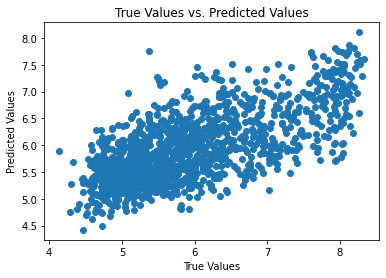

In [29]:
plt.scatter(y_test, predictions_test)

# 添加标签和标题
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs. Predicted Values')

# 显示图表
plt.show()

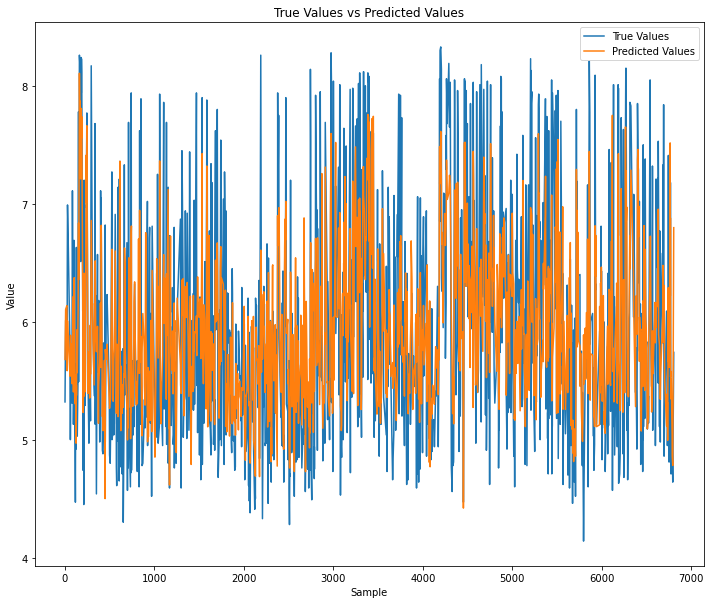

In [30]:
# 创建折线图
plt.figure(figsize=(12,10))
plt.plot(y_test, label='True Values')
plt.plot(predictions_test, label='Predicted Values')

# 图表标题和标签
plt.title('True Values vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [151]:
predictor.evaluate(test_data, silent=True)

{'root_mean_squared_error': -0.7042228411502366,
 'mean_squared_error': -0.4959298099977113,
 'mean_absolute_error': -0.5602155391544563,
 'r2': 0.4614920513034635,
 'pearsonr': 0.6814810237251692,
 'median_absolute_error': -0.4806458091735841}

In [205]:
perf = predictor.evaluate_predictions(y_train,y_train_pred,auxiliary_metrics=True,detailed_report=True)

Evaluation: r2 on test data: 0.8904053464492736
Evaluations on test data:
{
    "r2": 0.8904053464492736,
    "root_mean_squared_error": -0.31150275989535287,
    "mean_squared_error": -0.09703396942242187,
    "mean_absolute_error": -0.24527150490220473,
    "pearsonr": 0.9527501998016572,
    "median_absolute_error": -0.20375955581665028
}


In [152]:

def calculate_modified_r2(y_true, y_pred):
    diff = np.abs(y_true - y_pred)/y_true
    modified_diff = np.where(diff <= 0.08, 0, np.abs(y_true - y_pred))
    modified_ssr = np.sum(modified_diff**2)
    
    mean = np.mean(y_true)
    total_diff = np.sum((y_true - mean)**2)
    
    r2 = 1 - (modified_ssr / total_diff)
    return r2

print(calculate_modified_r2(test_data[label], y_test_pred))

0.5002818181730706


In [36]:
metrics = predictor.evaluate(test_data, silent=True)

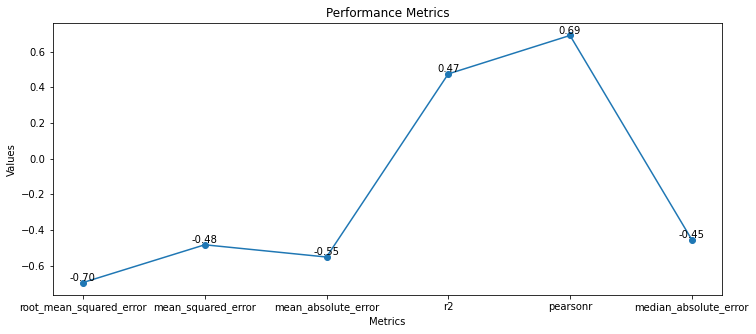

In [153]:
metric_names = list(metrics.keys())
metric_values = list(metrics.values())
plt.figure(figsize=(12,5))
plt.plot(metric_names, metric_values, marker='o')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics')

# 标注数值
for i in range(len(metric_names)):
    plt.annotate(f'{metric_values[i]:.2f}', (metric_names[i], metric_values[i]), ha='center', va='bottom')

plt.show()


In [154]:
fetures_value = predictor.feature_importance(train_data)
# 将索引添加为列

Computing feature importance via permutation shuffling for 10 features using 5000 rows with 5 shuffle sets...
	9.79s	= Expected runtime (1.96s per shuffle set)
	3.08s	= Actual runtime (Completed 5 of 5 shuffle sets)


In [155]:
df = fetures_value
df.reset_index(level=0, inplace=True)

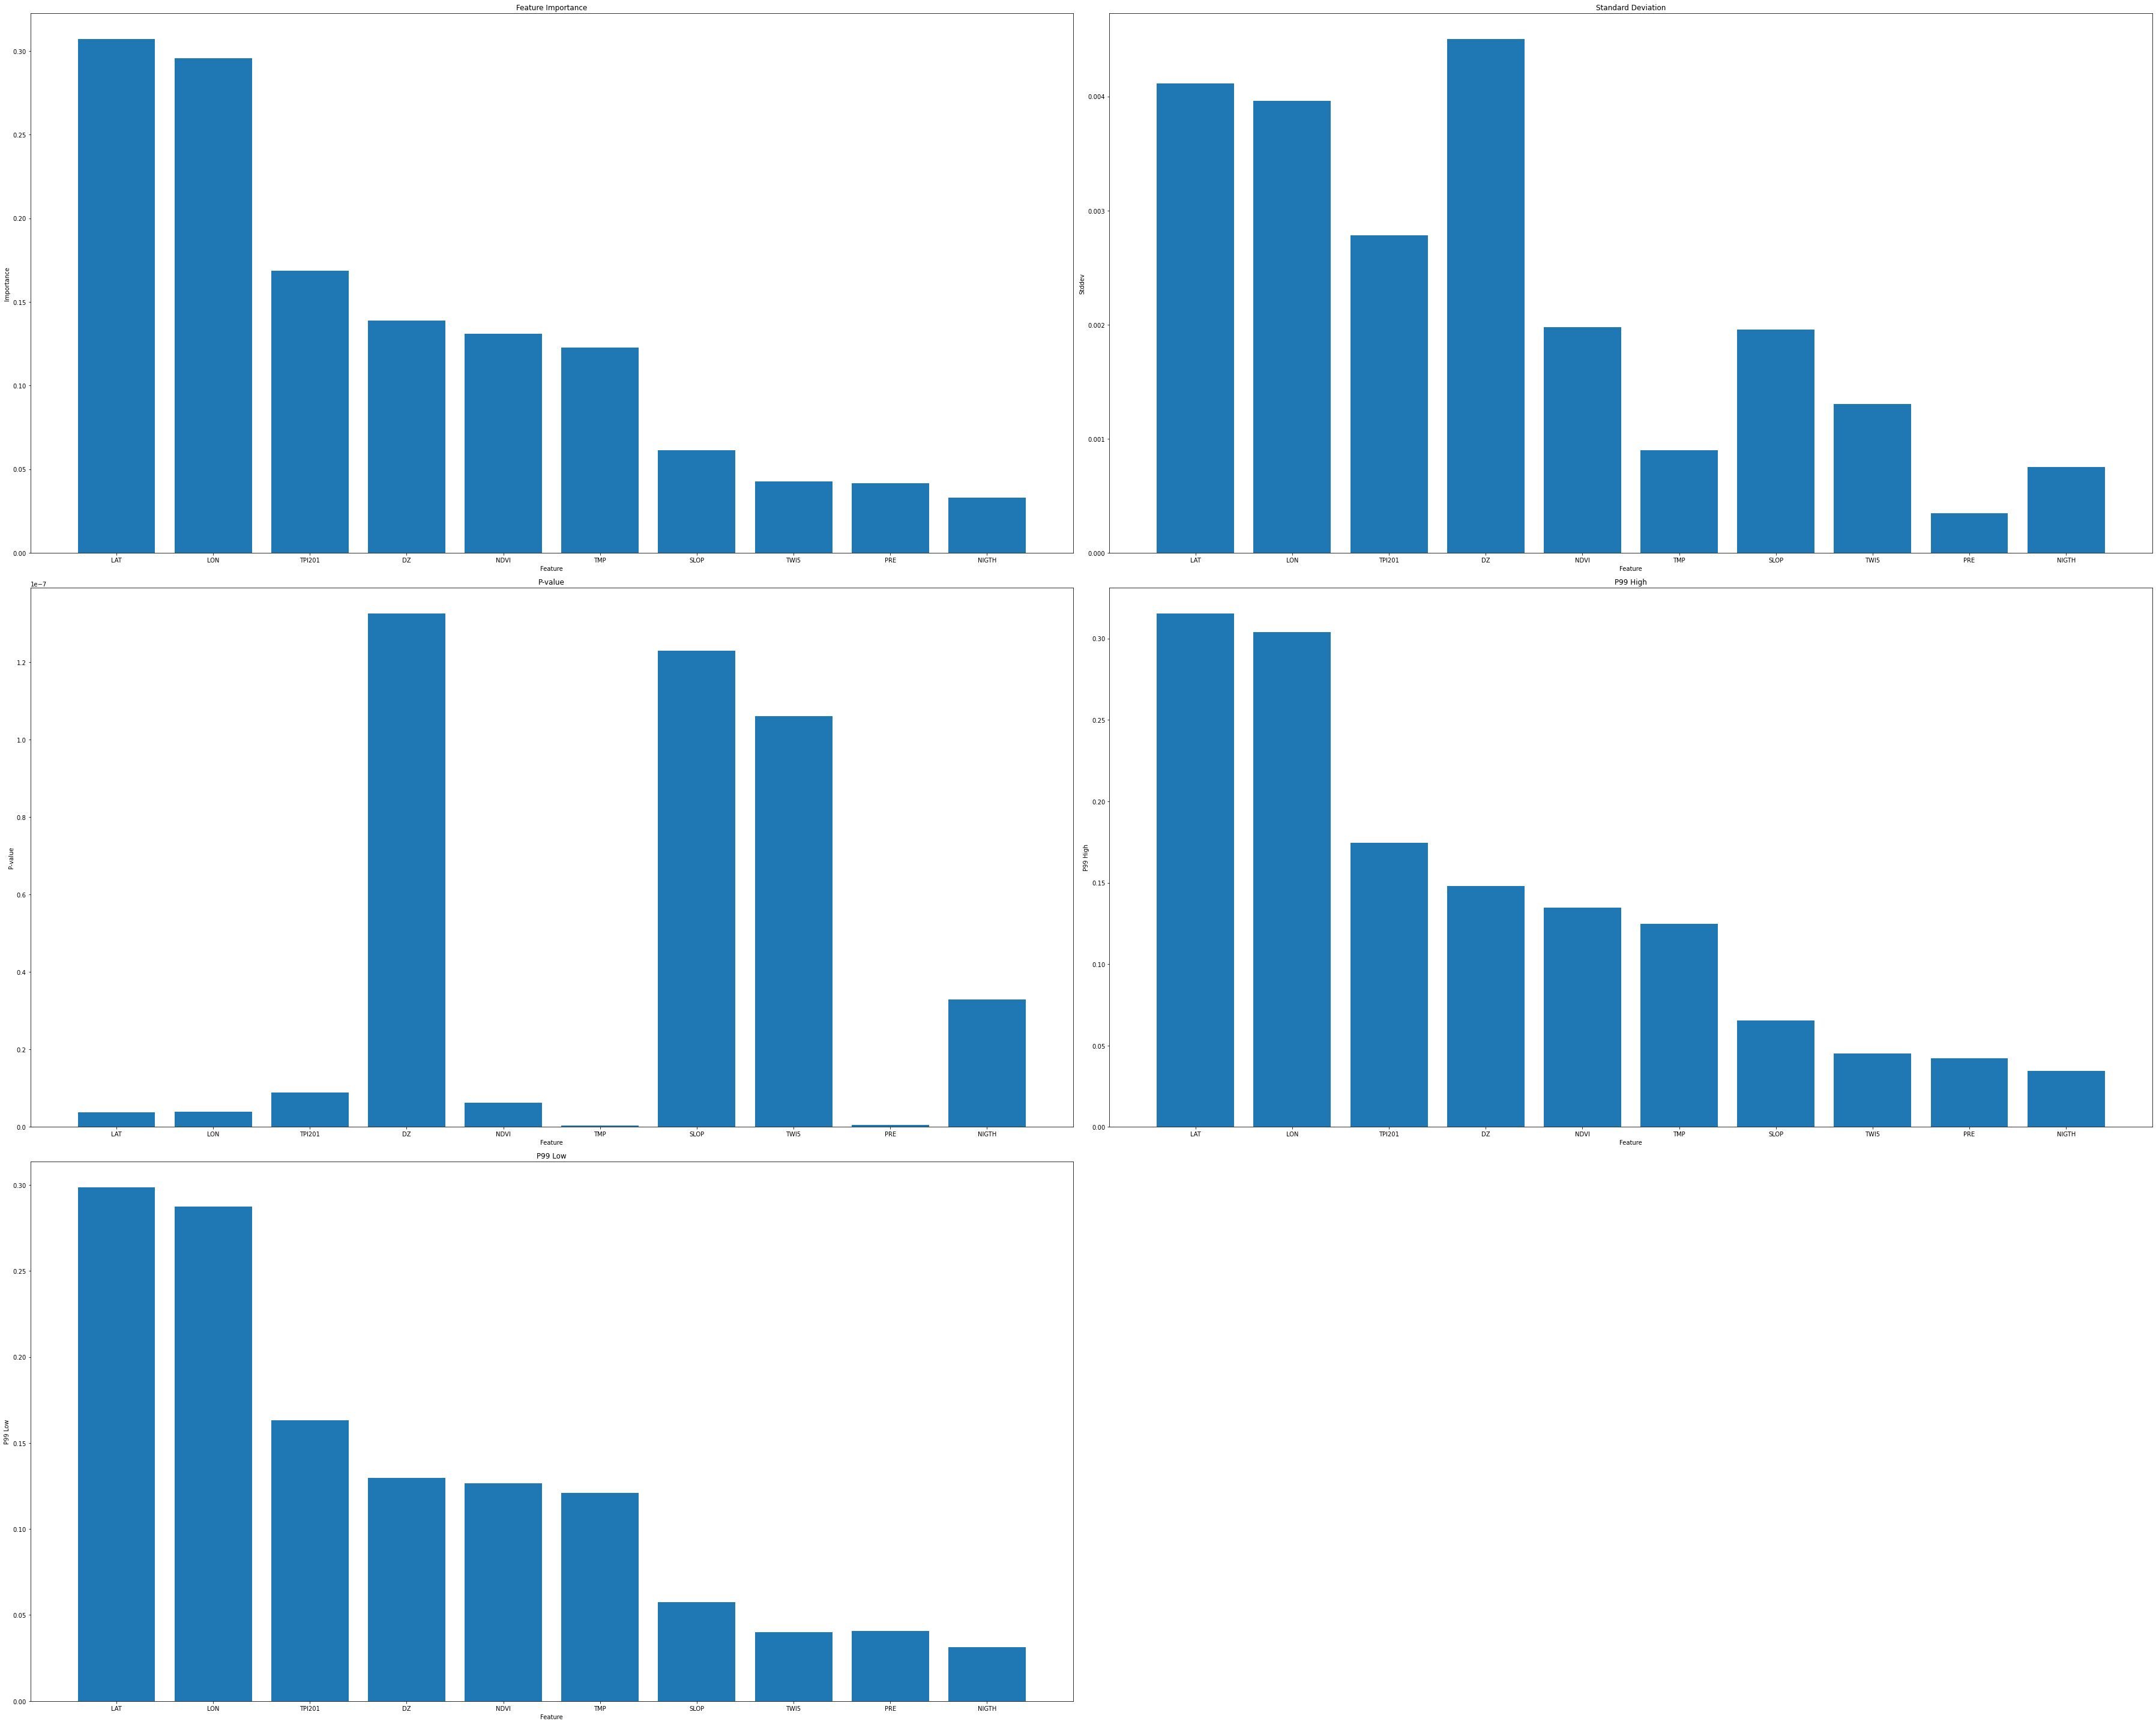

In [156]:
import matplotlib.pyplot as plt

# 设置图表大小
plt.figure(figsize=(50, 40))

# 绘制各个特征的重要性
plt.subplot(3, 2, 1)
plt.bar(df['index'], df['importance'])
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')

# 绘制各个特征的标准差
plt.subplot(3, 2, 2)
plt.bar(df['index'], df['stddev'])
plt.title('Standard Deviation')
plt.xlabel('Feature')
plt.ylabel('Stddev')

# 绘制各个特征的p值
plt.subplot(3, 2, 3)
plt.bar(df['index'], df['p_value'])
plt.title('P-value')
plt.xlabel('Feature')
plt.ylabel('P-value')

# 绘制各个特征的p99高值
plt.subplot(3, 2, 4)
plt.bar(df['index'], df['p99_high'])
plt.title('P99 High')
plt.xlabel('Feature')
plt.ylabel('P99 High')

# 绘制各个特征的p99低值
plt.subplot(3, 2, 5)
plt.bar(df['index'], df['p99_low'])
plt.title('P99 Low')
plt.xlabel('Feature')
plt.ylabel('P99 Low')

# 调整子图之间的间距
plt.tight_layout()

# 展示图表
plt.show()

In [ ]:
"""importance（重要性）：

取值范围：通常是一个非负实数，可以是介于0到无穷大之间的任意值。
意义：表示该特征对目标变量的预测能力的贡献程度。重要性值越高，说明该特征在预测模型中的影响力越大。
stddev（标准差）：

取值范围：通常是一个非负实数，可以是大于等于0的任意值。
意义：衡量特征值分散程度的统计指标。标准差值越大，表示样本数据在该特征上的波动越大。
p_value（P值）：

取值范围：通常是一个小于等于1的实数，可能是非负实数或者在特定情况下限制在0到1之间的实数。
意义：用于判断某个变量对目标变量是否具有显著影响。较小的p-value表示该特征与目标变量之间的关系更显著。
n（样本数量）：

取值范围：通常是一个正整数，表示用于计算这些特征参数的样本数量。
意义：表示用于计算特征参数的数据样本的数量。
p99_high（99%置信度上限）和p99_low（99%置信度下限）：

取值范围：通常是实数，可以是任意实数或在特定情况下限制在一定范围内的实数。
意义：表示特征的置信区间。在统计意义下，特征取值不会超过上限或低于下限的概率为99%。"""